In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [4]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [5]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [6]:
all_columns = list(etf_data.columns)

In [7]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [8]:
len(include_columns)

360

In [9]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [10]:
symbols = etf_list['Symbol'].unique()

In [11]:
len(symbols)

153

In [12]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504 #This is the first day that all variables are developed
# dt1 = 504 + 21 + 273 #This is the first day that all variables are developed 2016-04-07
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
dt_end = dt1 + 1
etf_predict_file = os.path.join(data_path,'etf_pred_linear_pca_with_poly_20180929.csv')
k=0

In [13]:

for i in range(dt1,dt_end,21):
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = np.ravel(y_train.as_matrix())

    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = np.ravel(y_test.as_matrix())
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()
    
    pca = PCA(n_components = 14)
    pca.fit(x_train_nmpy)

    print(pca.explained_variance_ratio_)
    print('Total variance captured = ',round(sum(pca.explained_variance_ratio_),4))

    x_train_new = pca.transform(x_train_nmpy)
    x_test_new = pca.transform(x_test_nmpy)

    poly = PolynomialFeatures(degree=3)
    x_train_poly = poly.fit_transform(x_train_new)
    x_test_poly = poly.fit_transform(x_test_new)

    lm = LinearRegression(n_jobs=32)

    lm.fit(x_train_poly, y_train_nmpy)

    y_pred_model = lm.predict(x_test_poly)
    y_train_model = lm.predict(x_train_poly)

    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)


    train_error = mean_squared_error(y_train_nmpy,y_train_model)
    eval_error = mean_squared_error(y_test_nmpy,y_pred_model)

    print('Model Eval Results:')
    print('*****************************')

    print(f'training error: {train_error:.3}')
    print(f'evaluation error: {eval_error:.3}')
    print('R-squared score (training): {:.3f}'
     .format(r2_score(y_train_nmpy, y_train_model)))
    print('R-squared score (test): {:.3f}'
     .format(r2_score(y_test_nmpy, y_pred_model)))

    print('*****************************')
    print("Model Top 5 Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model Bottom 5 Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    if i == dt1:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')

Building model to predict for  2015-02-05
[0.50534149 0.16456856 0.07525326 0.05501668 0.03866326 0.02287851
 0.02010547 0.01540546 0.01241954 0.01099241 0.00929365 0.00797082
 0.00671036 0.0057639 ]
Total variance captured =  0.9504
Model Eval Results:
*****************************
training error: 0.0441
evaluation error: 0.107
R-squared score (training): 0.471
R-squared score (test): -0.280
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0107
     true_value  pred_value  mkt_return   returns
104    0.869281    1.168428    0.010741  0.026336
60     0.189542    1.063281    0.010741 -0.029528
24     0.915033    0.991508    0.010741  0.040593
121    0.745098    0.991297    0.010741  0.012149
38     0.627451    0.987197    0.010741  0.004112
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0516
     true_value  pred_value  mkt_return   returns
49     0.150327   -0.217751    0.010741 -0.036237
18     0.215686   -0.319923    0.010741 -0.025901
55     0.006536   -0.348653    0.01

In [16]:
x_train_new.shape

(38556, 14)

In [15]:
x_train_poly.shape

(38556, 680)

In [25]:
y_check2 = np.column_stack((y_test_nmpy, y_pred_model,y_pred_model2,mkt_return_nmpy,returns_nmpy))
y_check2_df = pd.DataFrame(y_check2,columns=['true_value','pred_value','pred_value2','mkt_return','returns'])
y_check2_df.sort_values('pred_value',inplace=True,ascending=False)

In [17]:
lm.intercept_

0.5755055199247203

In [38]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,0.959006,w189_rank_p_L05_avg
1,0.959006,w189_rank_v_L05_avg
2,0.925984,w189_rank_p_L63_avg
3,0.925984,w189_rank_v_L63_avg
4,0.855843,w189_rank_v_L21_avg
5,0.855843,w189_rank_p_L21_avg
6,0.831051,w252_rank_p_L189_avg
7,0.831051,w252_rank_v_L189_avg
8,0.820546,w126_rank_v_L84_avg
9,0.820546,w126_rank_p_L84_avg


<IPython.core.display.Javascript object>


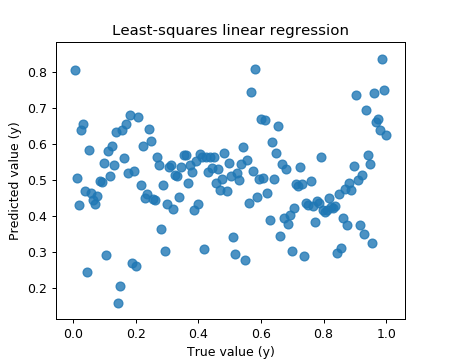

In [39]:
plt.figure(figsize=(5,4))
plt.scatter(y_test_nmpy, y_pred_model,marker= 'o', s=50, alpha=0.8)
#plt.plot(y_test_nmpy, y_pred_model, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('True value (y)')
plt.ylabel('Predicted value (y)')
plt.show()